<a href="https://colab.research.google.com/github/LisaATaylor/naip-classify/blob/master/SatelliteImageryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of satellite imagery tiles

The first few cells are the workflow for getting the DeepSat6 data from Kaggle.

In [0]:
initialsetup=False
if initialdownload:
  from google.colab import files
  #install kaggle
  !pip install -q kaggle
  #load kaggle API json
  uploaded = files.upload()

In [0]:
if initialsetup:
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d crawford/deepsat-sat6
  !unzip /content/*.zip

In [0]:
#save content to google drive to avoid downloading again
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#keep matlab formatted data (is most compact) and annotations
if initialsetup:
  !cp /content/sat-6-full.mat /content/gdrive/My\ Drive/Springboard/Data/DeepSat6/
  !cp /content/sat6annotations.csv /content/gdrive/My\ Drive/Springboard/Data/DeepSat6/

In [0]:
from scipy.io import loadmat
data=loadmat('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat-6-full.mat')

In [0]:
import numpy as np
import pandas as pd

def fixaxes(inarr): #matlab format has long axis in last position, move to 1st to match tensorflow
  return np.rollaxis(inarr,3,0)

#load ndarrays from mat dictionary
trainX=fixaxes(data['train_x']) 
trainy=data['train_y'].T
testX=fixaxes(data['test_x'])
testy = data['test_y'].T
#print(trx.shape)
assert np.all(trainX[0,:10,0,0] == data['train_x'][:10,0,0,0])


In [0]:
# get vector of categories for interpreting outputs

#X = df.values.reshape((-1, 28, 28, 4)).clip(0, 255).astype(np.uint8) # keep IR # (adapted from examples in https://www.kaggle.com/kmader/deepsat-overview-without-ir
#y = pd.read_csv('/content/y_train_sat6.csv',nrows=19200,header=None) 
#y=pd.DataFrame(trainy)
#get series of categories as text
anno=pd.read_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat6annotations.csv',header=None)
anno.head()
categories=anno.loc[:,0].to_dict()
ycat=pd.DataFrame(trainy).idxmax(axis=1).map(categories)

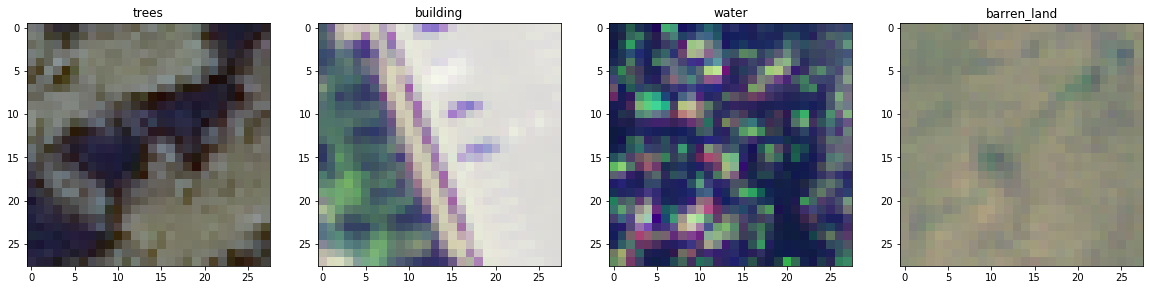

In [0]:
# look at a few tiles, visible bands
import matplotlib.pyplot as plt 
fig,axs=plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(trainX[0,:,:,:3])
axs[1].imshow(trainX[6,:,:,:3])
axs[2].imshow(trainX[2,:,:,:3])
axs[3].imshow(trainX[8,:,:,:3])
axs[0].set_title(ycat.loc[0])
axs[1].set_title(ycat.loc[6])
axs[2].set_title(ycat.loc[2])
axs[3].set_title(ycat.loc[8]);

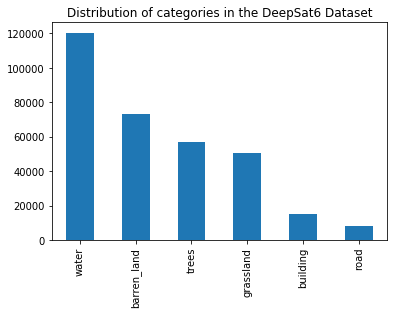

In [0]:
#look at balance between categories:  we see that the categories are not evenly distributed
ycounts=ycat.value_counts()
ycounts.plot.bar()
plt.title('Distribution of categories in the DeepSat6 Dataset');

In [0]:
#simple baseline CNN
from tensorflow.keras import models,layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28, 4))) #  RGB+IR images.
#model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())  #collapse to 1D
model.add(layers.Dense(512,activation='relu')) #reduce after flatten
model.add(layers.Dropout(0.5)) #added to reduce overfitting after updating image generator to use augmentation
model.add(layers.Dense(6,activation='softmax')) #final 6-way classification, predict class
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow(trainX[:280000],trainy[:280000],batch_size=512) #puts 280,000 images in train
val_generator=val_datagen.flow(trainX[280000:],trainy[280000:],batch_size=512) #puts 64,800 records in val

In [0]:
from tensorflow.keras import optimizers
load_weights=False
if load_weights:
    model.load_weights('/content/baseline.hdf5')
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(lr=0.01),metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=3)
if load_weights!=True:
    history=model.fit_generator(train_generator,steps_per_epoch=545,epochs=30,validation_data=val_generator,validation_steps=85,callbacks=[early_stop_mon])

Epoch 1/30
545/545 [==============================] - 20s 36ms/step - loss: 0.6286 - acc: 0.7601 - val_loss: 0.4148 - val_acc: 0.7912
Epoch 2/30
545/545 [==============================] - 20s 36ms/step - loss: 0.2926 - acc: 0.8793 - val_loss: 0.2795 - val_acc: 0.8780
Epoch 3/30
545/545 [==============================] - 20s 36ms/step - loss: 0.2336 - acc: 0.9047 - val_loss: 0.2163 - val_acc: 0.9090
Epoch 4/30
545/545 [==============================] - 21s 38ms/step - loss: 0.2011 - acc: 0.9188 - val_loss: 0.1728 - val_acc: 0.9299
Epoch 5/30
545/545 [==============================] - 21s 39ms/step - loss: 0.1796 - acc: 0.9271 - val_loss: 0.1731 - val_acc: 0.9262
Epoch 6/30
545/545 [==============================] - 21s 38ms/step - loss: 0.1627 - acc: 0.9344 - val_loss: 0.1376 - val_acc: 0.9432
Epoch 7/30
545/545 [==============================] - 21s 39ms/step - loss: 0.1512 - acc: 0.9390 - val_loss: 0.1300 - val_acc: 0.9455
Epoch 8/30
545/545 [==============================] - 21s 38ms

In [0]:
save_weights=True
if save_weights:
    model.save_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/baseline.hdf5')
    #dump history too
    hist_df=pd.DataFrame.from_dict(history.history)
    hist_df.to_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/history.csv')


In [0]:
model.load_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/baseline.hdf5')


In [0]:
hist=pd.read_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/history.csv')

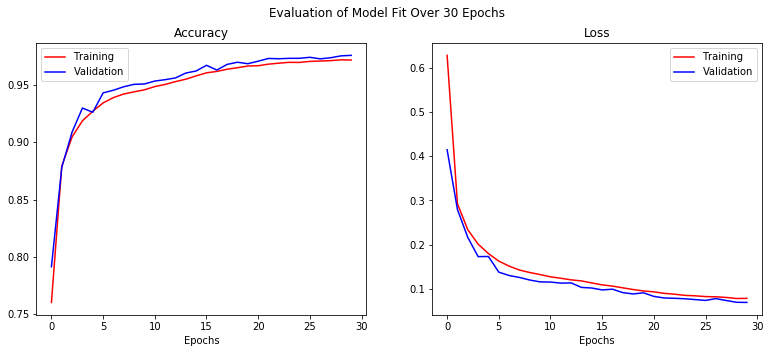

In [0]:
# Plot model fitting
# adapted from Deep Learning With Python (Chollet)
h=hist#history.history
epochs = range(len(h['acc']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['acc'], 'r', label='Training')
ax[0].plot(epochs, h['val_acc'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over 30 Epochs');


In [0]:
#try with data augmentation - performed slightly worse than unaugmented data set (results not shown below)
train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=90, #added image augmentation to increase training dataset size
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True,vertical_flip=True) #rescale to [0,1]

train_generator_aug=train_datagen_aug.flow(X[:16000],y.values[:16000],batch_size=64)

In [0]:
# Look at predictions on held-out data
testX_rescaled=testX/255
predy=model.predict(testX_rescaled)

In [0]:
#get pd Series of predicted and actual categories for test dataset
testycat=pd.DataFrame(testy).idxmax(axis=1).map(categories) #actual
testycat_pred=pd.DataFrame(predy).idxmax(axis=1).map(categories) #pred

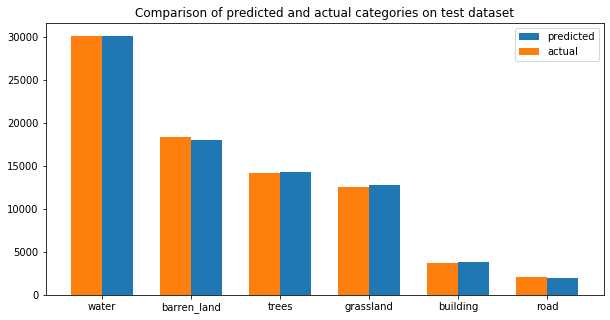

In [0]:
#Plot results
pred_df=testycat_pred.value_counts()
act_df=testycat.value_counts()
fig,ax=plt.subplots(figsize=(10,5))
ind=np.arange(6)
width=0.35
pred=ax.bar(ind+width,pred_df.values,width=width,label='predicted')
act=ax.bar(ind,act_df.values,width=width,label='actual')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(pred_df.index)
ax.legend()
ax.set_title('Comparison of predicted and actual categories on test dataset');

In [0]:
#get prediction errors
compare_df=pd.concat([testycat,testycat_pred],axis=1)
compare_df.columns=['actual','predicted']
compare_df=compare_df.assign(mismatch=compare_df.actual!=compare_df.predicted)
compare_df.loc[compare_df.mismatch].head()

,actual,predicted,mismatch
37,barren_land,grassland,True
92,barren_land,grassland,True
102,building,water,True
152,road,building,True
283,barren_land,grassland,True


In [0]:
compare_df['mismatch'].value_counts()

False    79074
True      1926
Name: mismatch, dtype: int64

In [0]:
#accuracy on test dataset
print('Overall accuracy on test dataset: {0:.3f}'.format(1-(compare_df.mismatch.sum()/compare_df.mismatch.count())))

Overall accuracy on test dataset: 0.976


In [0]:
# Look at confusion matrix, classification report
from sklearn.metrics import classification_report,confusion_matrix
print('Classification Report:')
print(classification_report(testycat,testycat_pred))
print('Confusion Matrix:')
print(confusion_matrix(testycat,testycat_pred))
print('\nNumber of Correct Classifications:')
correct=compare_df.loc[~compare_df.mismatch].groupby(['actual','predicted']).count()
correct.columns=['Correct']
print(correct) #check order of entries in confusion matrix

Classification Report:
              precision    recall  f1-score   support

 barren_land       0.98      0.96      0.97     18367
    building       0.95      0.97      0.96      3714
   grassland       0.93      0.95      0.94     12596
        road       0.93      0.87      0.90      2070
       trees       0.98      0.99      0.98     14185
       water       1.00      1.00      1.00     30068

    accuracy                           0.98     81000
   macro avg       0.96      0.96      0.96     81000
weighted avg       0.98      0.98      0.98     81000

Confusion Matrix:
[[17622     4   721     5    15     0]
 [    0  3614     1    92     1     6]
 [  358     0 11931    34   273     0]
 [    2   206    29  1793    11    29]
 [    2     0   137     0 14046     0]
 [    0     0     0     0     0 30068]]

Number of Correct Classifications:
                         Correct
actual      predicted           
barren_land barren_land    17622
building    building        3614
grassland   g

In [0]:
# roads have slightly lower recall wrt other categories (often misclassified as buildings)
# get indices of misclassifications of roads
road_mismatch=compare_df.loc[(compare_df.mismatch)&(compare_df.actual=='road')]
print(road_mismatch['predicted'].value_counts()) #roads most often misclassified as buildings
road_mismatch['ixcopy']=road_mismatch.index
mismatches=road_mismatch.groupby('predicted')['ixcopy'].first()

building       206
grassland       29
water           29
trees           11
barren_land      2
Name: predicted, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


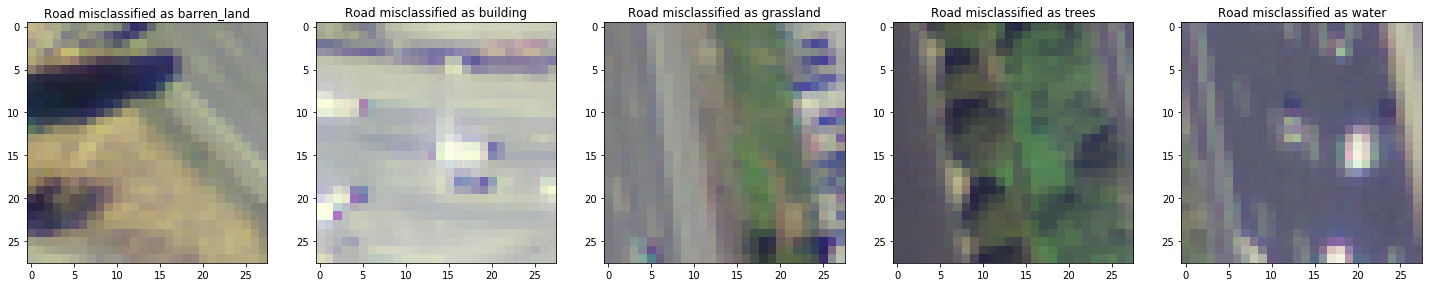

In [0]:
#view some mismatches
fig,axs=plt.subplots(1,5,figsize=(25,10))
axix=0
for i,v in mismatches.iteritems():
  axs[axix].imshow(testX[v,:,:,:3])
  axs[axix].set_title('Road misclassified as {}'.format(i))
  axix+=1

In [0]:
test_img.shape

(28, 28, 4)

### The following section is an attempt to fit the same data using transfer learning

(56, 56, 4)

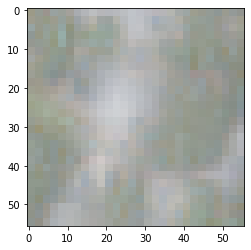

In [0]:
import cv2
resized=cv2.resize(test_img,(56,56),interpolation=cv2.INTER_AREA)
plt.imshow(resized)
resized.shape

In [0]:
#create array of enlarged images
count=0
X_big=np.empty((X.shape[0],56,56,4))
for img in X:
  #while count<10000:
    #print(img.shape)
  X_big[count]=cv2.resize(img,(56,56),interpolation=cv2.INTER_NEAREST)
  count+=1

In [0]:
print(X.shape)
print(X_big.shape)

(19200, 28, 28, 4)
(19200, 56, 56, 4)


In [0]:
X_big[19000,:4,:4,0]

array([[196., 196., 188., 188.],
       [196., 196., 188., 188.],
       [193., 193., 191., 191.],
       [193., 193., 191., 191.]])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen_big = ImageDataGenerator(rescale=1./255)  
val_datagen_big = ImageDataGenerator(rescale=1./255)

X_big=X_big[:,:,:,:3]# drop IR

train_rand=X_big[np.random.randint(16000)]
train_generator_big=train_datagen_big.flow(X_big[:16000],y.values[:16000],batch_size=128,shuffle=True) #puts 16000 records in train
val_generator_big=val_datagen_big.flow(X_big[16000:],y.values[16000:],batch_size=128,) #puts 3200 records in val

In [0]:
#try transfer learning with pretrained Resnet50
from tensorflow.keras import models,layers
from tensorflow.keras.applications import ResNet50
cbase=ResNet50(weights='imagenet',include_top=False,input_shape=(56,56,3)) 
cbase.trainable=False # freeze convolutional base
#set_trainable=False
#for layer in cbase.layers:
  #if layer.name == 'block5_conv1':
 ##  set_trainable = True
  #if set_trainable:
  #  layer.trainable = True
  #else:
   # layer.trainable = False
tmodel=models.Sequential()
tmodel.add(cbase)
tmodel.add(layers.Flatten())

tmodel.add(layers.Dense(1024,activation='relu'))
tmodel.add(layers.Dropout(0.5))
tmodel.add(layers.Dense(6,activation='softmax'))
tmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 6150      
Total params: 31,983,494
Trainable params: 8,395,782
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
from tensorflow.keras import optimizers
tmodel.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr=0.0001), metrics = ['accuracy'])

In [0]:
thistory=tmodel.fit_generator(train_generator_big,steps_per_epoch=120,epochs=30,validation_data=val_generator_big, validation_steps=50)

Epoch 1/30
120/120 [==============================] - 34s 285ms/step - loss: 2.2625 - acc: 0.2719 - val_loss: 1.6537 - val_acc: 0.3594
Epoch 2/30
120/120 [==============================] - 19s 158ms/step - loss: 1.5902 - acc: 0.3528 - val_loss: 1.6637 - val_acc: 0.3594
Epoch 3/30
120/120 [==============================] - 19s 158ms/step - loss: 1.4457 - acc: 0.4179 - val_loss: 1.7022 - val_acc: 0.3594
Epoch 4/30
 83/120 [===================>..........] - ETA: 4s - loss: 1.3291 - acc: 0.4699

KeyboardInterrupt: ignored

In [0]:
(19200-16000)/64

50.0

In [0]:
X.shape

(19200, 28, 28, 4)

In [0]:
X_big[19000,:4,:4,0]

array([[196., 196., 188., 188.],
       [196., 196., 188., 188.],
       [193., 193., 191., 191.],
       [193., 193., 191., 191.]])

In [0]:
X[0,:4,:4,0]

array([[116, 108,  67,  47],
       [122, 113,  64,  61],
       [105, 110,  95,  94],
       [120, 113,  97, 115]], dtype=uint8)

In [0]:
y.shape

(19200, 6)

In [0]:
X_big[16000:].shape

(3200, 56, 56, 3)

In [0]:
X_big[18001].max()

184.0

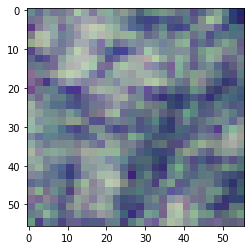

In [0]:
plt.imshow(X_big[0].astype('int'))

In [0]:
X_big[1000,:,:,2]

array([[107., 107., 115., ..., 100.,  99.,  99.],
       [107., 107., 115., ..., 100.,  99.,  99.],
       [121., 121., 114., ..., 104.,  97.,  97.],
       ...,
       [132., 132., 142., ..., 113., 113., 113.],
       [129., 129., 148., ..., 108., 110., 110.],
       [129., 129., 148., ..., 108., 110., 110.]])

In [0]:
X[1000,:,:,2]

array([[86, 82, 76, 77, 78, 76, 89, 78, 78, 90, 91, 87, 81, 79, 77, 78,
        81, 81, 76, 76, 78, 82, 81, 76, 73, 76, 77, 78],
       [81, 80, 77, 76, 80, 75, 76, 73, 72, 82, 86, 92, 90, 82, 77, 78,
        78, 74, 78, 80, 77, 79, 81, 79, 77, 77, 79, 75],
       [79, 81, 75, 72, 72, 73, 79, 77, 75, 73, 84, 91, 87, 78, 76, 77,
        72, 76, 80, 75, 78, 71, 74, 75, 74, 79, 76, 71],
       [79, 81, 72, 71, 76, 77, 77, 75, 77, 77, 84, 85, 87, 85, 83, 79,
        74, 72, 72, 75, 77, 79, 77, 74, 73, 75, 80, 75],
       [82, 81, 76, 76, 81, 78, 74, 80, 80, 81, 81, 83, 81, 78, 84, 82,
        76, 77, 75, 73, 79, 86, 84, 75, 77, 78, 78, 74],
       [80, 81, 78, 75, 76, 78, 77, 82, 84, 87, 82, 83, 80, 82, 89, 82,
        74, 73, 68, 74, 84, 89, 87, 80, 81, 77, 77, 76],
       [78, 78, 73, 74, 80, 82, 77, 80, 86, 92, 91, 81, 79, 80, 83, 83,
        78, 77, 76, 74, 80, 80, 90, 77, 76, 75, 77, 73],
       [81, 79, 73, 76, 74, 73, 72, 82, 81, 93, 95, 84, 77, 73, 77, 80,
        75, 76, 76, 78, 7